# Исследование объявлений о продаже квартир в Санкт-Петербурге

Содержание:

1. [Введение](#intro)  
    * [Этапы работы](#plan)
2. [Общая информация о данных](#general_info)
    * [Изучим данные](#first_study) 
3. [Предобработка данных](#preprocessing)
    * [Анализ типов данных](#types) 
    * [Проверка на явные и неявные дубликаты дубликаты](#dubl) 
    * [Очистка данных от выбросов ](#clean) 
    * [Создание новых столбцов](#new_columns)
3. [Исследовательский анализ данных](#research)
    * [Общие данные по параметрам объектов](#param)
    * [Как быстро продавались квартиры](#speed)
    * [Факторы, влияющие на общую (полную) стоимость объекта](#factors)
    * [Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений](#mean_1scrm_in_10)
    * [Средняя цена каждого километра до центра города для Санкт-Петербурга](#mean_1sqrkm)
4. [Вывод по исследованию](#conclusion) 

<a id="intro"></a> 
# Введение

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо определить рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Цель исследования — определить параметры, влияющие на стоимость объектов недвижимости, для дальнейшего создания автоматизированной системы.

<a id="plan"></a> 
## Этапы работы

Из предоставленного файла мы получили несколько параметров разного рода, этого достаточно для решения задачи.
Первым этапом задачи будет анализ первичных данных, обнаружение ошибок. Вторым этапом работы будет предобработка, устранение пропусков, дубликатов и экстремальных значений. Третим этапом мы дополним таблицу необходимыми данными для дальнейшей обработки информации. Четвертый этап - непосредственный анализ полученных данных, выявление взаимосвязей и зависимостей. Пятым этапом опишем выводы и результаты проделанной работы.</div>

<a id="general_info"></a> 
# Общая информация о данных:

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

<a id="first_study"></a> 
## Изучим данные 

In [1]:
# Импортируем все необходимые библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Прочитаем файл:
data = pd.read_csv(r'E:\Analytics\real_estate_data.csv', sep='\t')

In [3]:
# Найдем количество объявлений
total_ads = data.shape[0]
display('Всего объявлений:',total_ads)

'Всего объявлений:'

23699

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

По общей информации о датасете можно обнаружить следующее:
 - пропуски содержаться в колонках: ceiling_height, floors_total, living_area, is_apartment, kitchen_area, locality_name,  airports_nearest, cityCenters_nearest, parks_around3000,  parks_nearest, ponds_around3000, ponds_nearest, days_exposition. Пропуски везде, где количество не нулевых значений отличается от количества объявлений, и, '0' не является возможным значением в колонке (как, например - balcony). Проанализируем эти пропуски.
 - По типу данных в колонках: вызывают подозрения следующие колонки, где тип данных не соответствует возможным:floors_total - "всего этажей в доме" может быть только целым числом, в колонке указано, что это число дробное; is_apartment - должно быть булевым значением, в колонке содержаться строки;  balcony - не может быть дробным числом.
 

In [5]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Выведем минимальное и максимальное значения столбца first_day_exposition, для этого изменим формат представления даты:

In [6]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

display(min(data['first_day_exposition']), max(data['first_day_exposition']))

Timestamp('2014-11-27 00:00:00')

Timestamp('2019-05-03 00:00:00')

Первое объявление было создано 27 ноября 2014 года, а последнее - 3 мая 2019 года.

<a id="preprocessing"></a> 
# Предобработка данных

Чтобы найти взаимосвязи разных параметров в объявлениях необходимо подготовить и очистить данные. Найдем и изучим пропущенные значения в столбцах  в процентах:

In [7]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Как и было определено ранее при начальном анализе у нас 14 колонок с пропусками. Причин пропусков может быть несколько: от ошибки при заполнении объявлений, когда отсутствие, например, балкона вместо "0" было никак не отображено, до технической ошибки при объединении таблиц или выгрузке данных.

Заполним пропуски, где это возможно.

1) Категория помещения: апартаменты - да, или нет.

In [8]:
data['is_apartment'].unique()

array([nan, False, True], dtype=object)

В колонке is_apartment - присутсвуют пропуски, скорее всего эти значения "False", объект не аппаратаменты. Заменим пропуски на "False" и проверим:

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)
data['is_apartment'].unique()

array([False,  True])

Пропуски в колонке is_apartment заполнены.

2) Расстояние до ближайшего парка (м) - parks_nearest: примем допущение, что пропуски в этой колонке обусловлены отсутствием парков. Заменим пропуски на значение - 9999.

In [10]:
data['parks_nearest'] = data['parks_nearest'].fillna('9999').astype(int)

3) Аналогичным образом поступим для ближайших водоемов - ponds_nearest:

In [11]:
data['ponds_nearest'] = data['ponds_nearest'].fillna('9999').astype(int)

4) Заменим пропуски в колонке с количеством парков на ближайшие 3 км от объекта на "0".

In [12]:
data['parks_around3000'] = data['parks_around3000'].fillna('0').astype(int)

5) Заменим пропуски в колонке с количеством водоемов на ближайшие 3 км от объекта на "0".

In [13]:
data['ponds_around3000'] = data['ponds_around3000'].fillna('0').astype(int)

6) Заменим пропуски в количестве балконов на "0", считая что они обусловлены отутствием блаконов.

In [14]:
data['balcony'] = data['balcony'].fillna('0').astype(int)

7) Заменим пропуски в количестве этажей на "этаж" объявления, считая, что пропуск обусловлен тем фактом, что "этаж объявления"  - последний.

In [15]:
data['floors_total'] = data['floors_total'].fillna(data['floor']).astype(int)

8) Заменим пропуски о длительности объявления до закрытия медианами - days_exposition:

In [16]:
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median()).astype(int)

9) Касательно пропусков в "ближайших аэропортах" - заменим медианными значениями столбца.

In [17]:
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median()).astype(float)


10) Касательно пропусков в данных в "расстоянии до центра города" - заполним пропуски медианными значениями столбца. 

In [18]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median()).astype(float)

11) Заменим пропуски в "названии населенного пункта" на "Нет данных":

In [19]:
data['locality_name'] = data['locality_name'].fillna('Нет данных').astype(object)

12) Обработаем пропуски в данных о площади кухонь. Для этого примем, что площадь кухни соразмерна площадям квартир. 

In [20]:
kitchen_area_median = data.groupby('total_area')['kitchen_area'].median() #сгруппировали данные по общей площади объектов и кухонь

for value in kitchen_area_median.index:
    data.loc[(data['total_area']==value)&(data['kitchen_area'].isna()),'kitchen_area']=kitchen_area_median[value] # заменили пропуски медианным значением площади кухни для объектов разной площади
data['kitchen_area'].isna().sum()

205

13) Обработаем пропуски в данных о жилой площади объектов недвижимости. Примем, что жилая площадь соразмерна общим площадям квартир. 

In [21]:
living_area_median = data.groupby('total_area')['living_area'].median() # сгруппировали данные по общей площади объектов 
for value in living_area_median.index:
    data.loc[(data['total_area']==value)&(data['living_area'].isna()),'living_area']=living_area_median[value]# заменили пропуски медианным значением 
data['living_area'].isna().sum()

143

14) Обработаем пропуски в данных о высоте потолков объектов недвижимости. Примем, что высота потолков коррелирует с расположением объекта недвижимости. 

In [22]:
ceiling_height_median = data.groupby('locality_name')['ceiling_height'].median() # сгруппировали данные по названию населенного пункта
for value in ceiling_height_median.index:
    data.loc[(data['locality_name']==value)&(data['ceiling_height'].isna()),'ceiling_height'] = ceiling_height_median[value]# заменили пропуски медианным значением 
data['ceiling_height'].isna().sum()

121

Снова проверим пропуски в исходной таблице:

In [23]:
data.isna().sum()

total_images              0
last_price                0
total_area                0
first_day_exposition      0
rooms                     0
ceiling_height          121
floors_total              0
living_area             143
floor                     0
is_apartment              0
studio                    0
open_plan                 0
kitchen_area            205
balcony                   0
locality_name             0
airports_nearest          0
cityCenters_nearest       0
parks_around3000          0
parks_nearest             0
ponds_around3000          0
ponds_nearest             0
days_exposition           0
dtype: int64

Как видно - не от всех пропусков возможно избавиться, так как для их вычисления используются данные, в которых также есть пропуски.

<a id="types"></a> 
##  Анализ типов данных

В ходе предобработки выше был изменен тип данных для некоторых столбцов. Это необходимо сделать для дальнейшего использования этих данных, так как некоторые методы требуют определенного типа данных на входе.

In [24]:
# изменим тип данных столбца 'last_price'
data['last_price'].astype(int)

0        13000000
1         3350000
2         5196000
3        64900000
4        10000000
           ...   
23694     9700000
23695     3100000
23696     2500000
23697    11475000
23698     1350000
Name: last_price, Length: 23699, dtype: int32

<a id="dubl"></a> 
## Проверка на явные и неявные дубликаты 

In [25]:
data.duplicated().sum()

0

Явных дубликатов нет. Далее будем искать и избавляться от неявных дубликатов.

####  Удаление неявных дубликатов 

Изучим уникальные значения в столбце с названиями населенных пунктов и устраним неявные дубликаты.

In [26]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Слишком много данных для ручной проверки. Отсортируем для удобства:

In [27]:
sorted(data['locality_name'].unique(),key=lambda x:x.split()[-1])

['деревня Агалатово',
 'посёлок Александровская',
 'посёлок Алексеевка',
 'посёлок Аннино',
 'поселок Аннино',
 'деревня Аро',
 'поселок Барышево',
 'деревня Батово',
 'деревня Бегуницы',
 'деревня Старые Бегуницы',
 'деревня Белогорка',
 'посёлок Белоостров',
 'Бокситогорск',
 'поселок городского типа Красный Бор',
 'Сосновый Бор',
 'посёлок городского типа Красный Бор',
 'деревня Чудской Бор',
 'деревня Бор',
 'деревня Трубников Бор',
 'посёлок Пансионат Зелёный Бор',
 'поселок Пансионат Зелёный Бор',
 'посёлок Бугры',
 'поселок Бугры',
 'городской посёлок Будогощь',
 'деревня Ваганово',
 'посёлок городского типа Важины',
 'деревня Вартемяги',
 'деревня Малое Верево',
 'поселок станции Вещево',
 'посёлок при железнодорожной станции Вещево',
 'городской посёлок Виллози',
 'посёлок городского типа Вознесенье',
 'посёлок Возрождение',
 'поселок Возрождение',
 'поселок Войсковицы',
 'посёлок Войскорово',
 'поселок Володарское',
 'Волосово',
 'Волхов',
 'деревня Большая Вруда',
 'Всеволож

Можно видеть, что столбец содержит много неявных дубликатов. Заменим буквы "ё" на "е", а также некоторые названия населенных пунктов:

In [28]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции','поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок Кудрово','Кудрово')
data['locality_name'] = data['locality_name'].str.replace('поселок Мурино','Мурино')
data['locality_name'] = data['locality_name'].str.replace('поселок станции Приветнинское','Приветнинское')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции Приветнинское','Приветнинское')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество Приладожский','поселок Приладожский')
data['locality_name'] = data['locality_name'].str.replace('садовое товарищество Рахья','поселок Рахья')
data['locality_name'] = data['locality_name'].str.replace('поселок станции Вещево','поселок Вещево')
data['locality_name'] = data['locality_name'].str.replace('поселок Любань','Любань')

sorted(data['locality_name'].unique(),key=lambda x:x.split()[-1])

['деревня Агалатово',
 'поселок Александровская',
 'поселок Алексеевка',
 'поселок Аннино',
 'деревня Аро',
 'поселок Барышево',
 'деревня Батово',
 'деревня Бегуницы',
 'деревня Старые Бегуницы',
 'деревня Белогорка',
 'поселок Белоостров',
 'Бокситогорск',
 'поселок Красный Бор',
 'Сосновый Бор',
 'деревня Чудской Бор',
 'деревня Бор',
 'деревня Трубников Бор',
 'поселок Пансионат Зеленый Бор',
 'поселок Бугры',
 'поселок Будогощь',
 'деревня Ваганово',
 'поселок Важины',
 'деревня Вартемяги',
 'деревня Малое Верево',
 'поселок Вещево',
 'поселок Виллози',
 'поселок Вознесенье',
 'поселок Возрождение',
 'поселок Войсковицы',
 'поселок Войскорово',
 'поселок Володарское',
 'Волосово',
 'Волхов',
 'деревня Большая Вруда',
 'Всеволожск',
 'Выборг',
 'поселок Вырица',
 'деревня Выскатка',
 'поселок Высокоключевой',
 'Высоцк',
 'поселок Гаврилово',
 'деревня Гарболово',
 'поселок Гарболово',
 'Гатчина',
 'поселок Гладкое',
 'поселок Глажево',
 'поселок Глебычево',
 'деревня Глинка',
 'пос

<a id="clean"></a> 
## Очистка данных от выбросов

In [29]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23578.000000,23699.000000,23556.000000,23699.000000,23494.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000,23699.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.734311,10.671463,34.465702,5.892358,10.457529,0.591080,28310.148023,13936.792797,0.469049,6757.651800,0.590911,6354.454492,169.360226
std,5.682529,1.088701e+07,35.654083,1.078405,1.011986,6.595802,21.834917,4.885249,5.782501,0.959298,11090.330161,7553.779633,0.748534,4511.522493,0.883999,4615.391407,206.535633
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,21183.000000,10927.000000,0.000000,601.000000,0.000000,637.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13098.500000,0.000000,9999.000000,0.000000,9999.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.300000,8.000000,11.810000,1.000000,34327.000000,15248.500000,1.000000,9999.000000,1.000000,9999.000000,199.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,9999.000000,3.000000,9999.000000,1580.000000


Анализируя таблицу с распределениями значений по столбцам видим следующее:
 - максимальное количество фотографий (50шт.) сильно отличается от медианы (9шт.) - все бывает, это не повод удалять такие строки.
 - данные по цене - трудно анализировать, оставим без изменений.
 - данные по общей площади - явный выброс данных - 900 квадратных метров.
 - данные по количеству комнат - также вызывает сомнения.
 - высота потолков - явные выбросы.
 - количество этажей - самое высотное здание по СПБ и области - Лахта-центр. Населенный пункт из таблицы с 60-этажами - Кронштадт. Значит - выброс!
 - жилая площадь - выбросы.
 - площадь кухни - выбросы.
 - этаж и последующие столбцы - не вызывают сомнений.

Проанализируем выбросы по высоте потолков:

In [30]:
data['ceiling_height'].unique()

array([  2.7  ,   2.63 ,   3.03 ,   2.6  ,   2.64 ,   2.5  ,   2.67 ,
         2.55 ,   2.56 ,   3.05 ,   2.75 ,   2.9  ,   2.56 ,   2.8  ,
         3.   ,   2.65 ,   3.2  ,   2.61 ,     nan,   3.25 ,   3.45 ,
         2.77 ,   2.85 ,   2.525,   2.57 ,   4.15 ,   3.5  ,   3.3  ,
         2.71 ,   4.   ,   2.47 ,   2.73 ,   2.84 ,   3.1  ,   2.34 ,
         3.4  ,   2.52 ,   3.06 ,   2.72 ,   2.54 ,   2.51 ,   2.78 ,
        13.85 ,   2.76 ,  25.   ,   2.58 ,   3.7  ,   5.2  ,   2.87 ,
         2.66 ,   2.59 ,   2.   ,   2.45 ,   3.6  ,   3.9  ,   2.92 ,
         3.11 ,   3.13 ,   3.8  ,   3.15 ,   3.55 ,   3.16 ,   3.62 ,
         3.12 ,   2.53 ,   2.74 ,   2.96 ,   2.46 ,   5.3  ,   5.   ,
         2.79 ,   2.95 ,   4.06 ,   2.94 ,   3.82 ,   3.54 ,   3.53 ,
         2.83 ,   4.7  ,   2.4  ,   3.38 ,   3.01 ,   5.6  ,   3.65 ,
         3.18 ,   3.35 ,   2.3  ,   3.57 ,   2.48 ,   2.515,   2.62 ,
         2.82 ,   2.65 ,   3.98 ,   2.875,   3.83 ,  27.   ,   3.52 ,
         3.95 ,   3.

Для корректной очистки данных изучим выбросы выбросы и аномалии данных и удалим их. Используем метод boxplot():

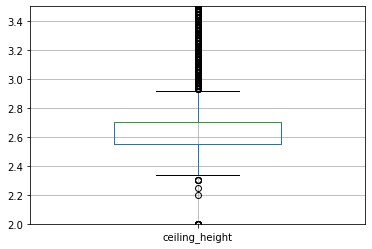

In [31]:
data.boxplot(figsize=(20, 10))
plt.ylim(2, 3.5)
plt.xlim(4.5, 5.5)
plt.show()

В столбце 'ceiling_height' очень много выбросов. Теоретически, все что выходит за границу 'усов', следует удалить. Оставим в качестве максимальной высоты потолков значение 3.3м. Это значение введу в фильтр ниже для обновленной таблицы data_new_filter.

Полагая, что при вводе данных была ошибка (высота потолка 24 м), заменим данные в таблице:

In [32]:
data['ceiling_height'] = data['ceiling_height'].replace(24.0,2.4)
data['ceiling_height'] = data['ceiling_height'].replace(27.,2.7)
data['ceiling_height'] = data['ceiling_height'].replace(25.,2.5)
data['ceiling_height'] = data['ceiling_height'].replace(26.,2.6)
data['ceiling_height'] = data['ceiling_height'].replace(22.6,2.26)
data['ceiling_height'] = data['ceiling_height'].replace(20.,2.0)
data['ceiling_height'] = data['ceiling_height'].replace(27.5,2.75)
data['ceiling_height'].unique()


array([  2.7  ,   2.63 ,   3.03 ,   2.6  ,   2.64 ,   2.5  ,   2.67 ,
         2.55 ,   2.56 ,   3.05 ,   2.75 ,   2.9  ,   2.56 ,   2.8  ,
         3.   ,   2.65 ,   3.2  ,   2.61 ,     nan,   3.25 ,   3.45 ,
         2.77 ,   2.85 ,   2.525,   2.57 ,   4.15 ,   3.5  ,   3.3  ,
         2.71 ,   4.   ,   2.47 ,   2.73 ,   2.84 ,   3.1  ,   2.34 ,
         3.4  ,   2.52 ,   3.06 ,   2.72 ,   2.54 ,   2.51 ,   2.78 ,
        13.85 ,   2.76 ,   2.58 ,   3.7  ,   5.2  ,   2.87 ,   2.66 ,
         2.59 ,   2.   ,   2.45 ,   3.6  ,   3.9  ,   2.92 ,   3.11 ,
         3.13 ,   3.8  ,   3.15 ,   3.55 ,   3.16 ,   3.62 ,   3.12 ,
         2.53 ,   2.74 ,   2.96 ,   2.46 ,   5.3  ,   5.   ,   2.79 ,
         2.95 ,   4.06 ,   2.94 ,   3.82 ,   3.54 ,   3.53 ,   2.83 ,
         4.7  ,   2.4  ,   3.38 ,   3.01 ,   5.6  ,   3.65 ,   3.18 ,
         3.35 ,   2.3  ,   3.57 ,   2.48 ,   2.515,   2.62 ,   2.82 ,
         2.65 ,   3.98 ,   2.875,   3.83 ,   3.52 ,   3.95 ,   3.75 ,
         2.88 ,   3.

Рассмотрим объекты в разрезе площади:

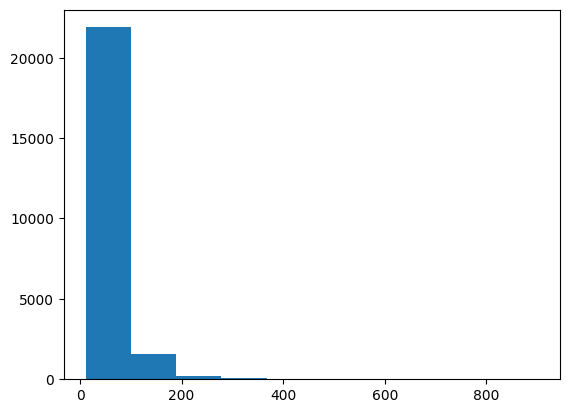

In [33]:
plt.hist(data['total_area'])
plt.show()

Касательно выбросов по общей площади и жилой площади - из гистограммы выше видно, что оъектов с общей площадью более 200м2 ничтожно мало. А именно:

In [34]:
persent_total_area = len(data[data['total_area']>=200])/len(data['total_area'])*100
round(persent_total_area,2)

0.97

Менее 1% данных в столбце с общей площадью, где общая площадь более 200м2. 
Для наших рсчетов эти данные можно удалить. 
Аналогично нужно избавиться от данных в стобцах с жилой площадью, количестом комнат , высотой потолков, площадью кухни и количеством этажей. Создадим новую таблицу по фильтрам для выбросов.

In [35]:
data_new = data.query('(total_area<=200) and (rooms<=6) and (ceiling_height>=2.5) and (ceiling_height<6) and (floors_total<=30) and (living_area<=160) and (kitchen_area<=40)').reset_index()
data_new.describe()

,index,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,22841.000000,22841.000000,2.284100e+04,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000
mean,11846.907885,9.859463,5.949417e+06,57.927407,2.033799,2.698641,10.686091,33.243073,5.884593,10.105466,0.591962,28339.283306,14028.438028,0.462589,6775.581323,0.580097,6388.120748,169.004947
std,6835.721074,5.664924,5.894054e+06,25.719614,0.975934,0.213034,6.522007,17.066376,4.858244,4.531878,0.957848,11172.058969,7560.508372,0.739914,4505.169952,0.872716,4605.118047,205.597171
min,0.000000,0.000000,4.300000e+05,14.000000,0.000000,2.500000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,5935.000000,6.000000,3.450000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,20998.000000,11020.000000,0.000000,604.000000,0.000000,646.000000,45.000000
50%,11853.000000,9.000000,4.600000e+06,51.800000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13098.500000,0.000000,9999.000000,0.000000,9999.000000,95.000000
75%,17755.000000,14.000000,6.650000e+06,68.500000,3.000000,2.700000,16.000000,42.000000,8.000000,11.500000,1.000000,34519.000000,15319.000000,1.000000,9999.000000,1.000000,9999.000000,199.000000
max,23698.000000,50.000000,3.300000e+08,200.000000,6.000000,5.800000,29.000000,159.600000,27.000000,40.000000,5.000000,84869.000000,65968.000000,3.000000,9999.000000,3.000000,9999.000000,1580.000000


Новая таблица содержит 22841 строки, в исходной 23699

In [36]:
lost_persent = (100*(len(data)-len(data_new)))/len(data)
print(f"После фильтрации потеряли: {lost_persent}% данных.")

После фильтрации потеряли: 3.6204059243006035% данных.


Потеря 3,6% данных - это в пределах допустимого, можно двигаться дальше.

Посмотрим, сколько потеряем данных с новым фильтром по высоте потолка:

In [37]:
data_new_filter = data.query('(total_area<=200) and (rooms<=6) and (ceiling_height>=2.5) and (ceiling_height<3.3) and (floors_total<=30) and (living_area<=160) and (kitchen_area<=40)').reset_index()
data_new_filter.describe()

,index,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,22231.000000,22231.000000,2.223100e+04,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000,22231.000000
mean,11855.459314,9.838064,5.753458e+06,56.972369,2.008592,2.674771,10.826369,32.596005,5.951824,10.002662,0.603077,28423.314606,14235.495614,0.443975,6864.395484,0.561558,6460.289686,167.699114
std,6833.903059,5.646097,4.892633e+06,24.606846,0.955307,0.150914,6.537906,16.229156,4.891929,4.422314,0.964030,11253.587953,7453.307215,0.721745,4472.854668,0.855916,4585.123276,204.086114
min,0.000000,0.000000,4.300000e+05,14.000000,0.000000,2.500000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,5953.500000,6.000000,3.400000e+06,40.000000,1.000000,2.550000,5.000000,18.500000,2.000000,7.000000,0.000000,20890.000000,11347.000000,0.000000,622.000000,0.000000,657.000000,45.000000
50%,11851.000000,9.000000,4.570000e+06,51.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26726.000000,13098.500000,0.000000,9999.000000,0.000000,9999.000000,95.000000
75%,17765.500000,14.000000,6.500000e+06,67.250000,3.000000,2.700000,16.000000,41.500000,8.000000,11.400000,1.000000,34947.000000,15426.000000,1.000000,9999.000000,1.000000,9999.000000,197.000000
max,23698.000000,50.000000,1.240000e+08,200.000000,6.000000,3.280000,29.000000,159.600000,27.000000,40.000000,5.000000,84869.000000,65968.000000,3.000000,9999.000000,3.000000,9999.000000,1580.000000


In [38]:
lost_persent_filter = (100*(len(data)-len(data_new_filter)))/len(data)
print(f"После фильтрации потеряли: {lost_persent_filter}% данных.")

После фильтрации потеряли: 6.194354192160007% данных.


In [39]:
data_new = data_new_filter

<a id="new_columns"></a> 
## Создание новых столбцов 

#### Добавим столбец с Ценой одного квадратного метра

In [40]:
data_new['1m2_price'] = data_new['last_price']/data_new['total_area']
data_new['1m2_price'] = round(data_new['1m2_price'],2)
# Проверим появление нового столбца
data_new.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m2_price
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,0,Санкт-Петербург,18863.0,16028.0,1,482,2,755,95,120370.37
1,1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,...,2,поселок Шушары,12817.0,18603.0,0,9999,0,9999,81,82920.79
2,2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,...,0,Санкт-Петербург,21741.0,13933.0,1,90,2,574,558,92785.71
3,3,0,64900000.0,159.0,2015-07-24,3,2.70,14,95.0,9,...,0,Санкт-Петербург,28098.0,6800.0,2,84,3,234,424,408176.10
4,5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,...,0,поселок Янино-1,26726.0,13098.5,0,9999,0,9999,55,95065.79


#### Добавим столбец с днем недели публикации объявления

In [41]:
data_new['day_expo'] = pd.DatetimeIndex(data_new['first_day_exposition']).day_name()
#Для удобства дальнейшего анализа добавим столбец с днями в числовом формате
data_new['day_expo_number'] = data_new['first_day_exposition'].dt.weekday
#Проверим
data_new.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m2_price,day_expo,day_expo_number
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,18863.0,16028.0,1,482,2,755,95,120370.37,Thursday,3
1,1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,...,12817.0,18603.0,0,9999,0,9999,81,82920.79,Tuesday,1
2,2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,...,21741.0,13933.0,1,90,2,574,558,92785.71,Thursday,3
3,3,0,64900000.0,159.0,2015-07-24,3,2.70,14,95.0,9,...,28098.0,6800.0,2,84,3,234,424,408176.10,Friday,4
4,5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,...,26726.0,13098.5,0,9999,0,9999,55,95065.79,Monday,0


#### Добавим столбец с месяцем публикации объявления

In [42]:
data_new['month_expo'] = pd.DatetimeIndex(data_new['first_day_exposition']).month_name()
#Для удобства дальнейших расчетов добавим также столбец с месяцами, выраженными в числовом формате
data_new['month_expo_number'] = data_new['first_day_exposition'].dt.month
data_new.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m2_price,day_expo,day_expo_number,month_expo,month_expo_number
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,1,482,2,755,95,120370.37,Thursday,3,March,3
1,1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,...,0,9999,0,9999,81,82920.79,Tuesday,1,December,12
2,2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,...,1,90,2,574,558,92785.71,Thursday,3,August,8
3,3,0,64900000.0,159.0,2015-07-24,3,2.70,14,95.0,9,...,2,84,3,234,424,408176.10,Friday,4,July,7
4,5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,...,0,9999,0,9999,55,95065.79,Monday,0,September,9


#### Добавим столбец с годом публикации объявления

In [43]:
data_new['year_expo'] = data_new['first_day_exposition'].dt.year
data_new.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,1m2_price,day_expo,day_expo_number,month_expo,month_expo_number,year_expo
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,482,2,755,95,120370.37,Thursday,3,March,3,2019
1,1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,...,9999,0,9999,81,82920.79,Tuesday,1,December,12,2018
2,2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,...,90,2,574,558,92785.71,Thursday,3,August,8,2015
3,3,0,64900000.0,159.0,2015-07-24,3,2.70,14,95.0,9,...,84,3,234,424,408176.10,Friday,4,July,7,2015
4,5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,...,9999,0,9999,55,95065.79,Monday,0,September,9,2018


#### Добавим столбец с типом этажа квартиры: первый, последний, другой.

In [44]:
# создадим функцию для категоризации этажей:
def floor_category(floor):
   
    if floor['floor']==1:
        return 'первый'
    elif floor['floor'] == floor['floors_total']:
        return 'последний'
    else:
        return 'другой'
        
data_new['floor_type'] = data[['floor','floors_total']].apply(floor_category, axis=1) 
data_new.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,ponds_around3000,ponds_nearest,days_exposition,1m2_price,day_expo,day_expo_number,month_expo,month_expo_number,year_expo,floor_type
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,2,755,95,120370.37,Thursday,3,March,3,2019,другой
1,1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,...,0,9999,81,82920.79,Tuesday,1,December,12,2018,первый
2,2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,...,2,574,558,92785.71,Thursday,3,August,8,2015,другой
3,3,0,64900000.0,159.0,2015-07-24,3,2.70,14,95.0,9,...,3,234,424,408176.10,Friday,4,July,7,2015,другой
4,5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,...,0,9999,55,95065.79,Monday,0,September,9,2018,другой


#### Добавим столбец с расстоянием до центра города в километрах 

In [45]:
# в 1 км - 1000 м:
data_new['cityCenters_nearest_km'] = (data_new['cityCenters_nearest'] / 1000).round()
data_new.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,ponds_nearest,days_exposition,1m2_price,day_expo,day_expo_number,month_expo,month_expo_number,year_expo,floor_type,cityCenters_nearest_km
0,0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,...,755,95,120370.37,Thursday,3,March,3,2019,другой,16.0
1,1,7,3350000.0,40.4,2018-12-04,1,2.63,11,18.6,1,...,9999,81,82920.79,Tuesday,1,December,12,2018,первый,19.0
2,2,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,...,574,558,92785.71,Thursday,3,August,8,2015,другой,14.0
3,3,0,64900000.0,159.0,2015-07-24,3,2.70,14,95.0,9,...,234,424,408176.10,Friday,4,July,7,2015,другой,7.0
4,5,10,2890000.0,30.4,2018-09-10,1,2.60,12,14.4,5,...,9999,55,95065.79,Monday,0,September,9,2018,другой,13.0


Новые столбцы добавлены, можно исследовать взаимосвязи данных.

<a id="research"></a> 
# Исследовательский анализ данных

<a id="param"></a> 
## Общие данные по параметрам объектов

Изучим общие сведения об общей площади объектов:

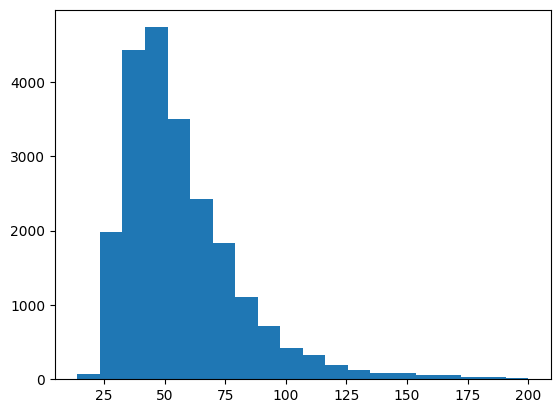

In [46]:
#data_new['total_area'].hist(bins=20, legend=True)
plt.hist(data_new['total_area'],bins=20)
plt.show()

In [47]:
# Посмотрим на статистику:
data_new['total_area'].describe() 

count    22231.000000
mean        56.972369
std         24.606846
min         14.000000
25%         40.000000
50%         51.000000
75%         67.250000
max        200.000000
Name: total_area, dtype: float64

Как видно из таблицы и гистограммы - медиана по общей площади объектов приходится на 51,8 м2. Минимальная площадь объекта - 14м2. Максимальная площадь - 200м2. Это значение превышает третий квартиль и смахивает на выброс - но общая площадь объекта в 200м2 - вполне реальна, поэтому было решено оставить это значение в выборке.

Изменим масштаб отображения гистограммы, возможно, есть интересные данные:

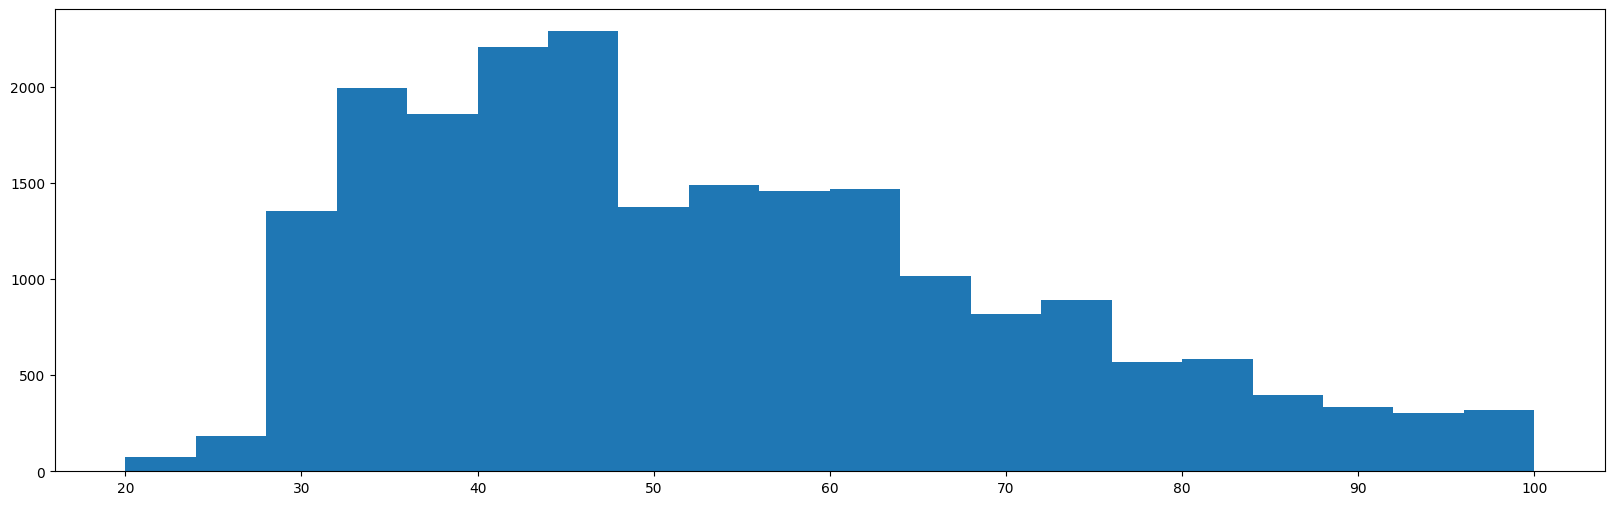

In [48]:
plt.figure(figsize=[20,6])
plt.hist(data_new['total_area'], range=(20,100), bins=20)
plt.show()

График приобрел другой вид, появились явные пики

Изучим общие сведения о жилой площади объектов:

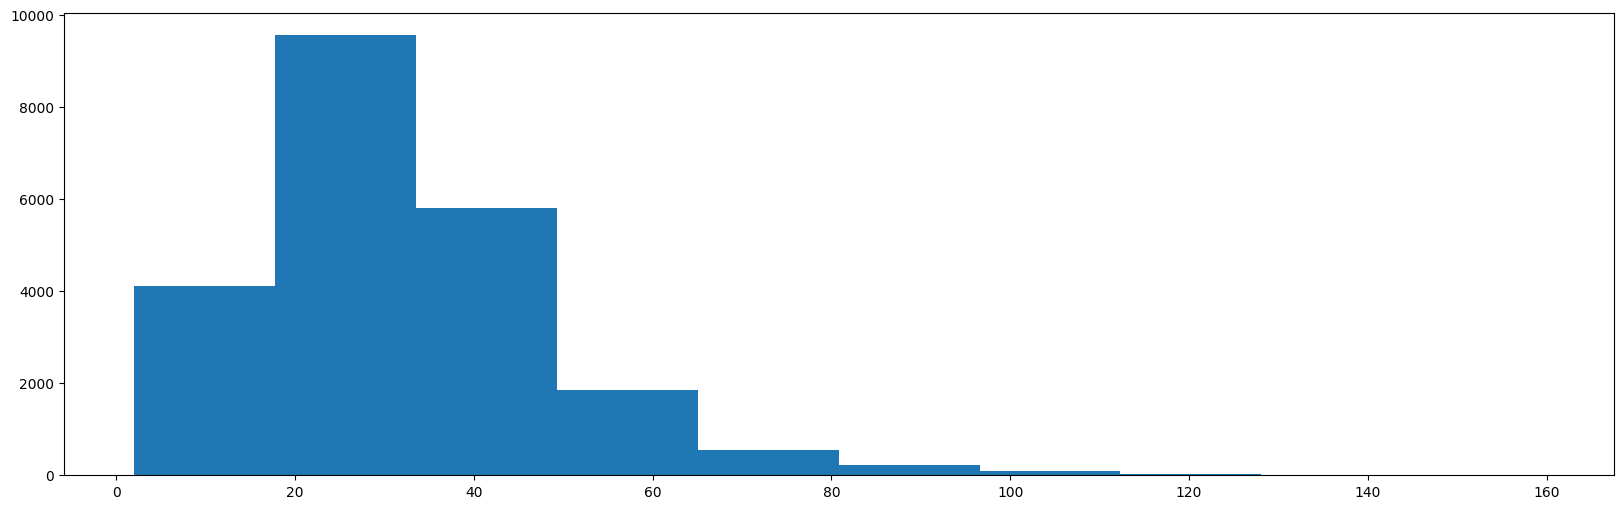

In [49]:
plt.figure(figsize=[20,6])
plt.hist(data_new['living_area'])
plt.show()

In [50]:
data_new['living_area'].describe() 

count    22231.000000
mean        32.596005
std         16.229156
min          2.000000
25%         18.500000
50%         30.000000
75%         41.500000
max        159.600000
Name: living_area, dtype: float64

Медиана по жилой площади объектов приходится на 30м2, минимальный размер жилой площади - 2м2, максимальный - 159м2.

Изучим общие сведения о площади кухонь объектов:

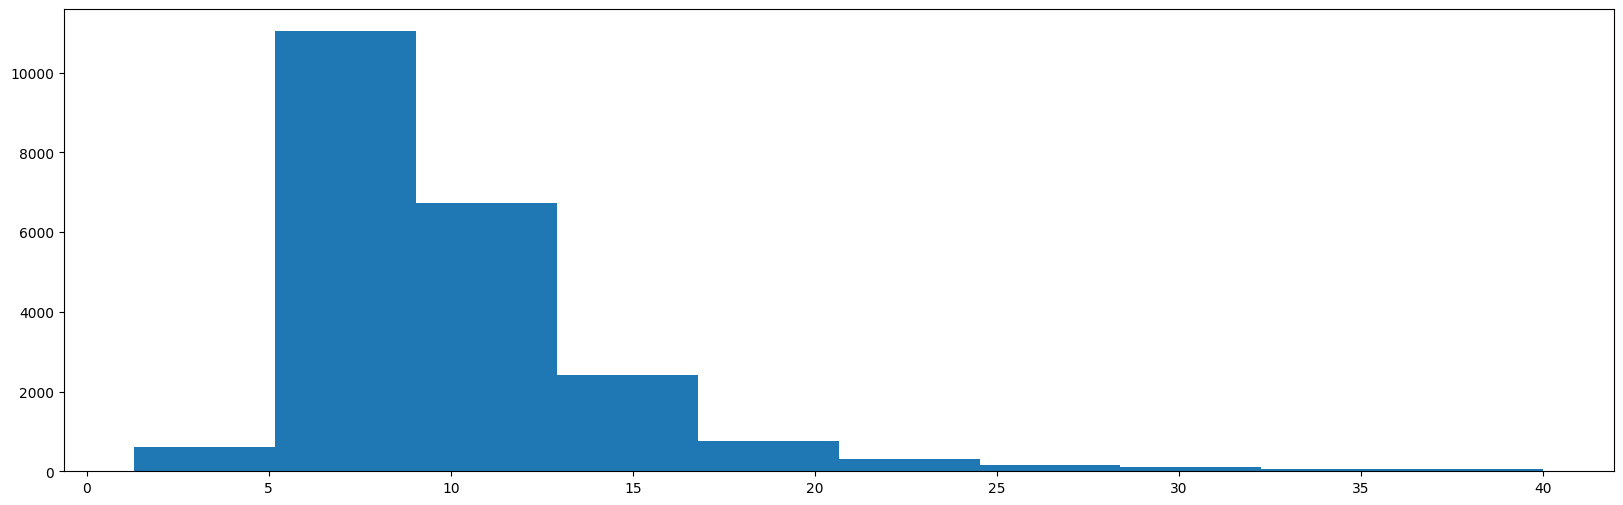

In [51]:
plt.figure(figsize=[20,6])
plt.hist(data_new['kitchen_area'])
plt.show()

In [52]:
data_new['kitchen_area'].describe() 

count    22231.000000
mean        10.002662
std          4.422314
min          1.300000
25%          7.000000
50%          9.000000
75%         11.400000
max         40.000000
Name: kitchen_area, dtype: float64

Медиана по площади кухонь приходится на 9м2, минимальный размер жилой площади - 1,3м2, максимальный - 40м2.

Изучим общие сведения о финальной цене объектов:

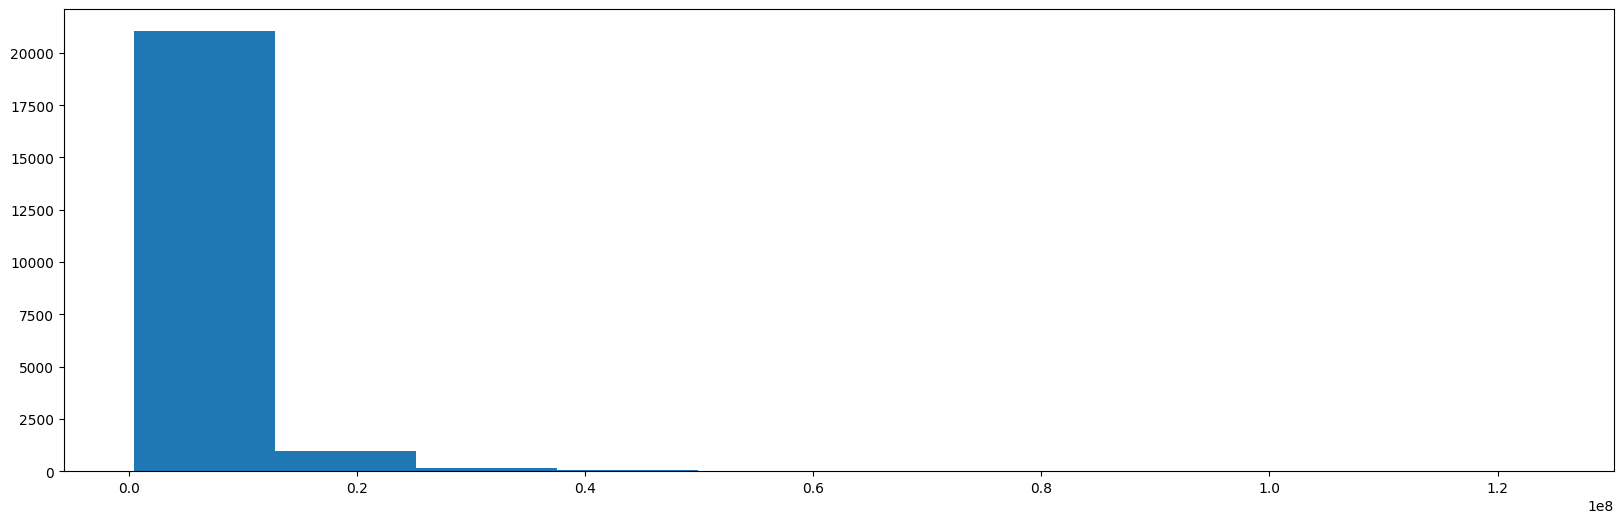

In [53]:
plt.figure(figsize=[20,6])
plt.hist(data_new['last_price'])
plt.show()

In [54]:
data_new['last_price'].describe()

count    2.223100e+04
mean     5.753458e+06
std      4.892633e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.570000e+06
75%      6.500000e+06
max      1.240000e+08
Name: last_price, dtype: float64

Медиана по стоимости объектов- 4.6*10^6 рублей (4 600 000 рублей), минимальная цена - 430 000 рублей, максимальная цена - 330 000 000 рублей.

Изучим данные по количеству комнат объектов:

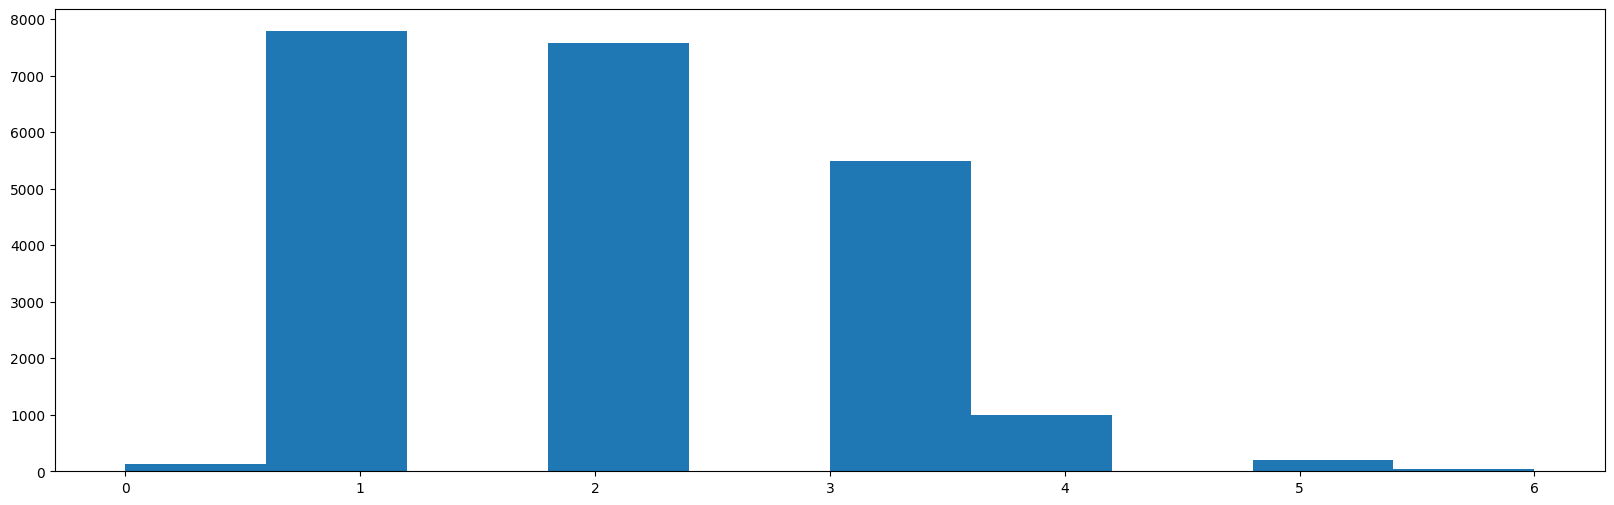

In [55]:
plt.figure(figsize=[20,6])
plt.hist(data_new['rooms'])
plt.show()

In [56]:
data_new['rooms'].describe()

count    22231.000000
mean         2.008592
std          0.955307
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: rooms, dtype: float64

In [57]:
data_new['rooms'].value_counts()

1    7785
2    7585
3    5490
4     992
5     198
0     136
6      45
Name: rooms, dtype: int64

Медиана и среднее приходится на двухкомнатные кваритиры, при этом больше всего продано объектов - однокомнатных и квартир-студий.

Изучим объекты по высоте потолков:

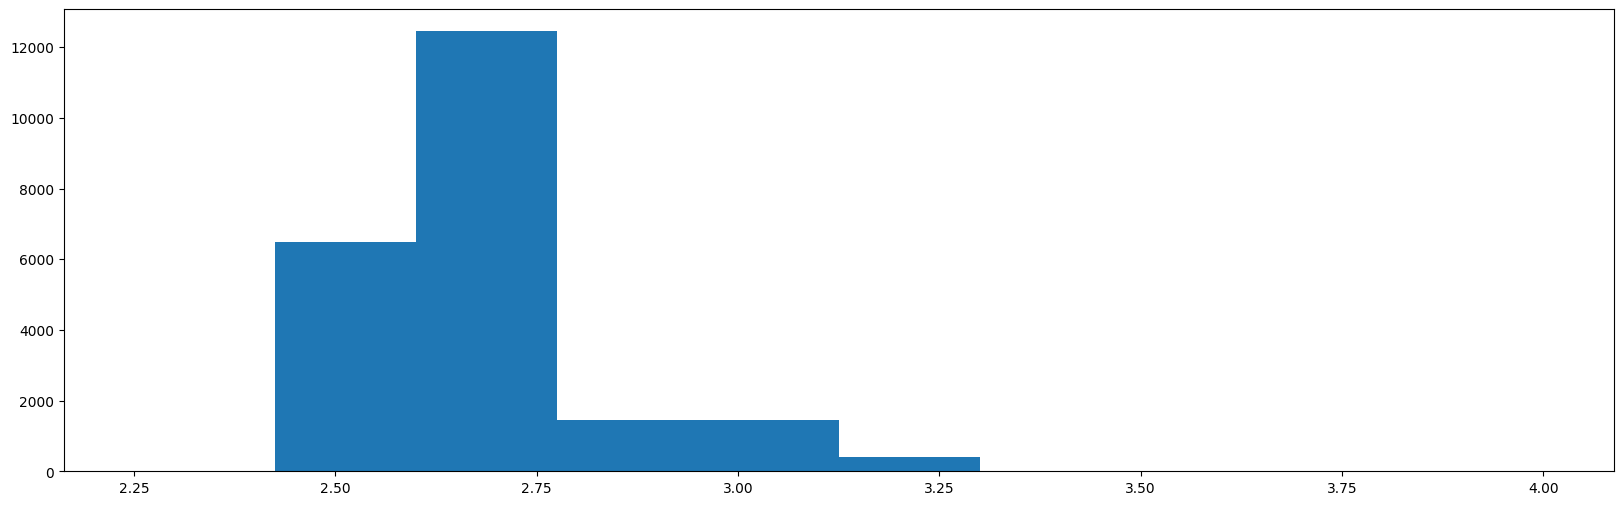

In [58]:
plt.figure(figsize=[20,6])
plt.hist(data_new['ceiling_height'], range=(2.25,4))
plt.show()

In [59]:
data_new['ceiling_height'].describe()

count    22231.000000
mean         2.674771
std          0.150914
min          2.500000
25%          2.550000
50%          2.700000
75%          2.700000
max          3.280000
Name: ceiling_height, dtype: float64

В среднем большинство объектов имеют высоту потолка - 2,7м. Максимальный размер высоты потолков - 5,8м. Минимальный - 2,5м.

Изучим объекты по этажу.

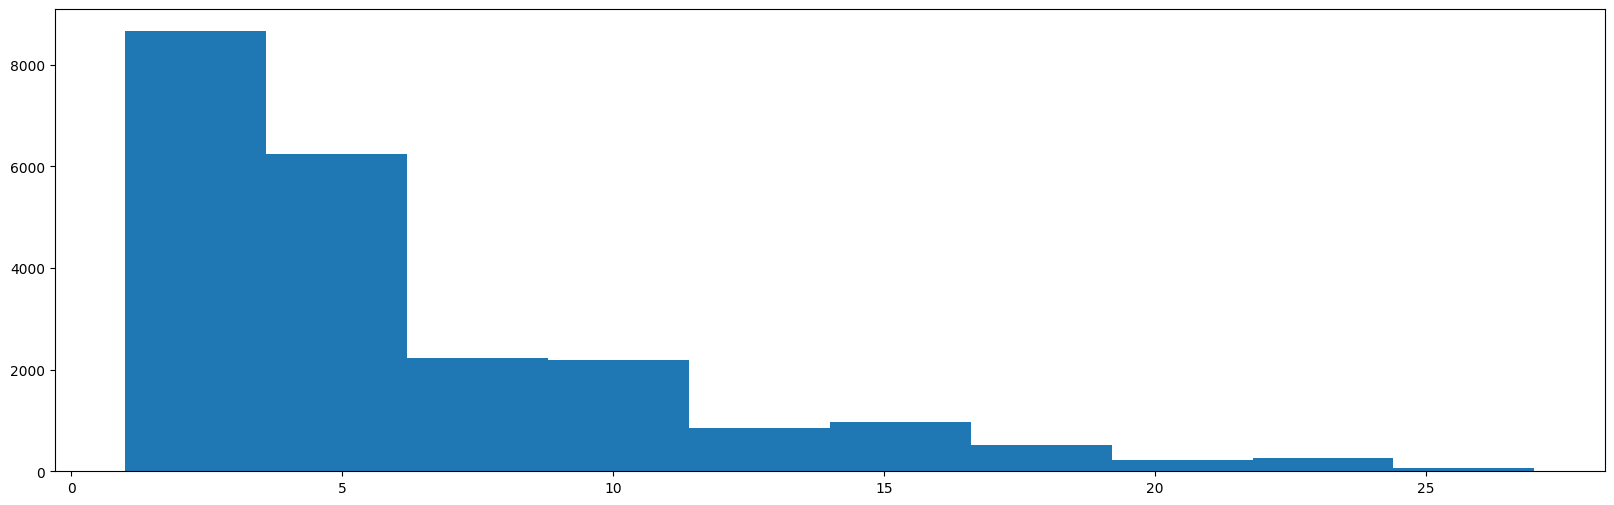

In [60]:
plt.figure(figsize=[20,6])
plt.hist(data_new['floor'])
plt.show()

In [61]:
data_new['floor'].describe()

count    22231.000000
mean         5.951824
std          4.891929
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64

In [62]:
data_new['floor'].value_counts()

2     3090
3     2834
1     2733
4     2573
5     2451
6     1226
7     1165
8     1057
9     1022
10     666
11     503
12     501
13     357
15     332
14     330
16     304
17     214
18     172
19     137
21     122
22     110
20     106
23      95
24      58
25      44
26      21
27       8
Name: floor, dtype: int64

Медиана по этажу приходится на 4 этаж, при этом больше всего объектов находится на 2 этаже. Максимальный этаж - 27. 

Изучим данные по типу этажа: первый, последний, другой.

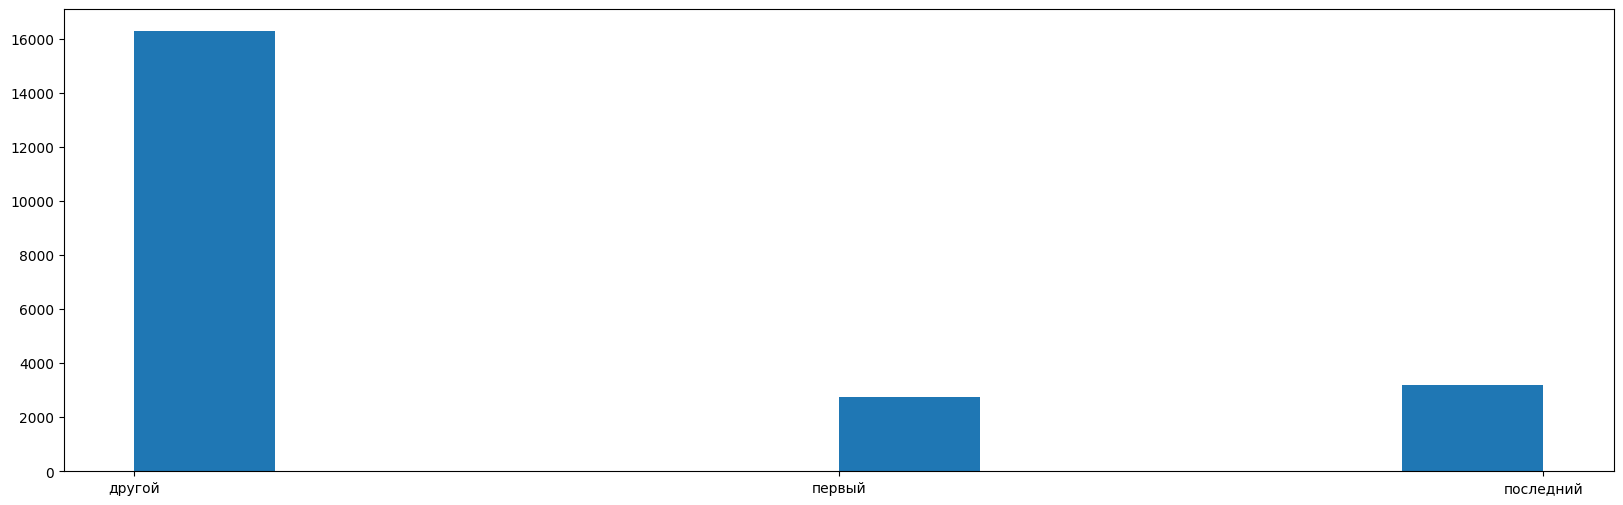

In [63]:
plt.figure(figsize=[20,6])
plt.hist(data_new['floor_type'])
plt.show()

In [64]:
data_new['floor_type'].describe()

count      22231
unique         3
top       другой
freq       16285
Name: floor_type, dtype: object

Больше всего объектов расположено между первым и последним этажом. Меньше всего объектов на первом этаже.

Изучим данные по общему количеству этажей в объектах.

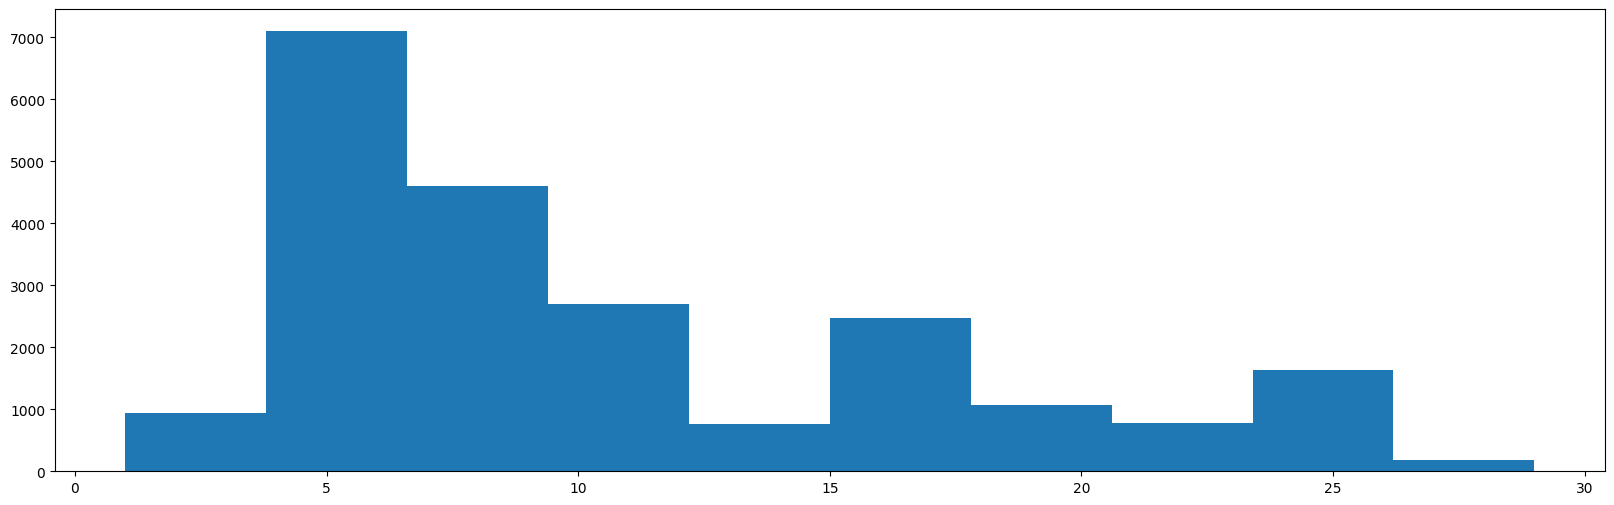

In [65]:
plt.figure(figsize=[20,6])
plt.hist(data_new['floors_total'])
plt.show()

In [66]:
data_new['floors_total'].describe()

count    22231.000000
mean        10.826369
std          6.537906
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64

Медиана приходится на 9-этажки. Больше всего объектов - в пятиэтажках. Минимальное количество этажей - 1.

Изучим данные о расстоянии до центра населенного пункта.

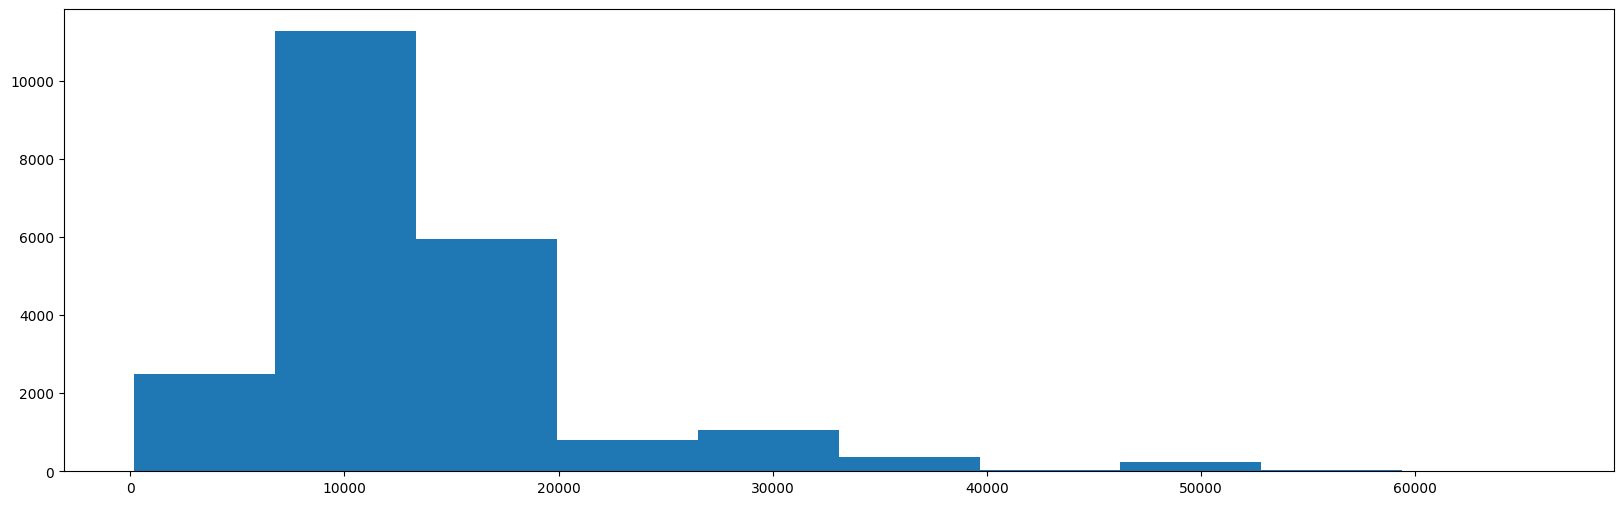

In [67]:
plt.figure(figsize=[20,6])
plt.hist(data_new['cityCenters_nearest'])
plt.show()

In [68]:
data_new['cityCenters_nearest'].describe()

count    22231.000000
mean     14235.495614
std       7453.307215
min        181.000000
25%      11347.000000
50%      13098.500000
75%      15426.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Медиана - 13098м. Минимальное расстояние - 181м. Больше всего объектов расположены на расстоянии больше 10км от центра населенного пункта.

Изучим данные по аэропортам.

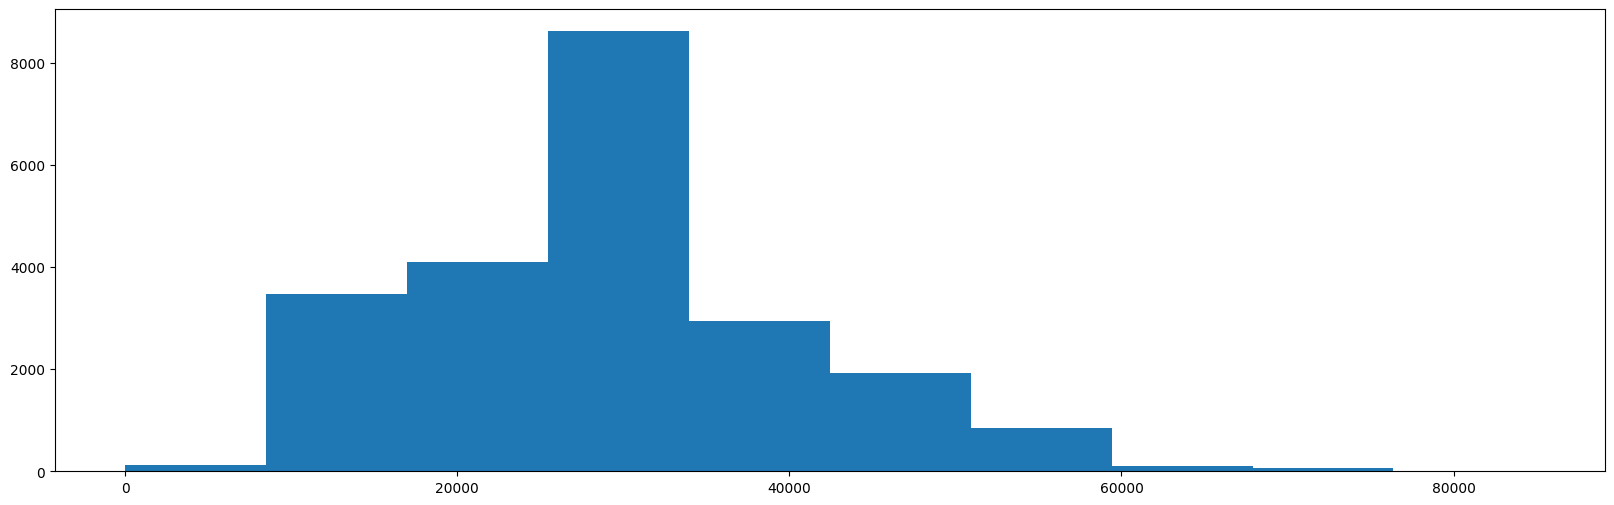

In [69]:
plt.figure(figsize=[20,6])
plt.hist(data_new['airports_nearest'])
plt.show()

In [70]:
data_new['airports_nearest'].describe()

count    22231.000000
mean     28423.314606
std      11253.587953
min          0.000000
25%      20890.000000
50%      26726.000000
75%      34947.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Большинство объектов находятся на расстоянии около 27км от аэропортов. Самый удаленный объект - находится на расстоянии более 80км от аэропорта.

Изучим данные по ближайшим паркам к объектам.

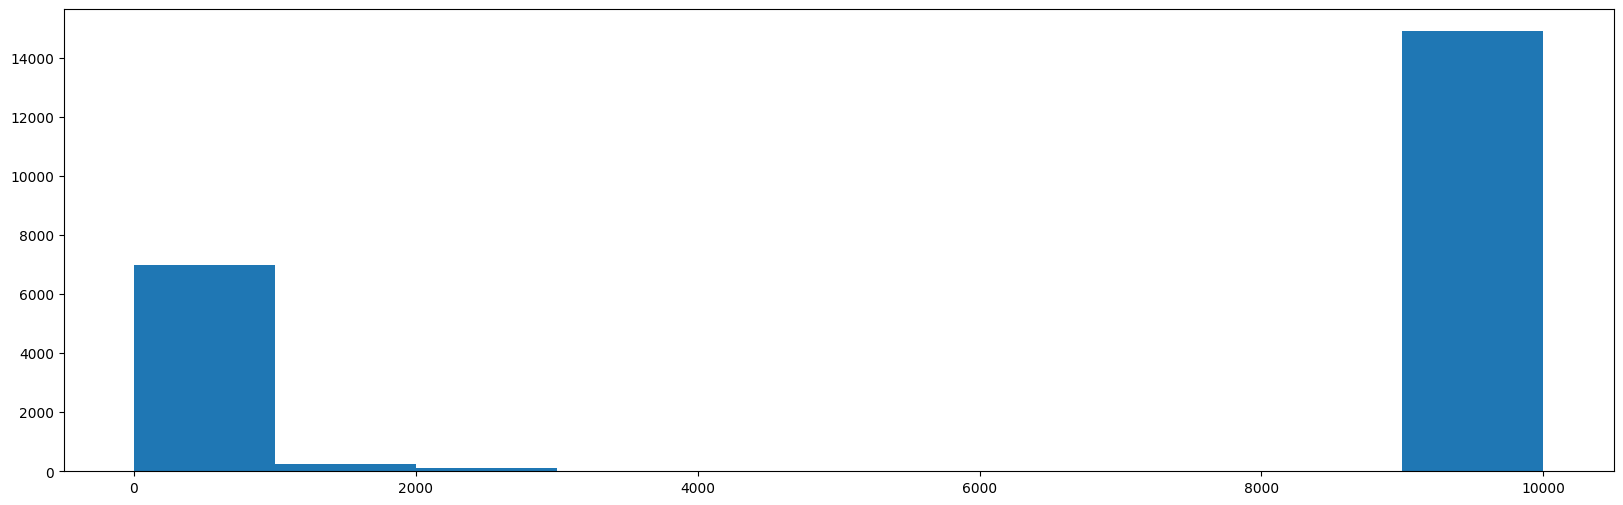

In [71]:
plt.figure(figsize=[20,6])
plt.hist(data_new['parks_nearest'])
plt.show()

In [72]:
data_new['parks_nearest'].describe()

count    22231.000000
mean      6864.395484
std       4472.854668
min          1.000000
25%        622.000000
50%       9999.000000
75%       9999.000000
max       9999.000000
Name: parks_nearest, dtype: float64

Для большинства объектов парки находятся на значительном удалении.  

Изучим данные по месяцу публикации.

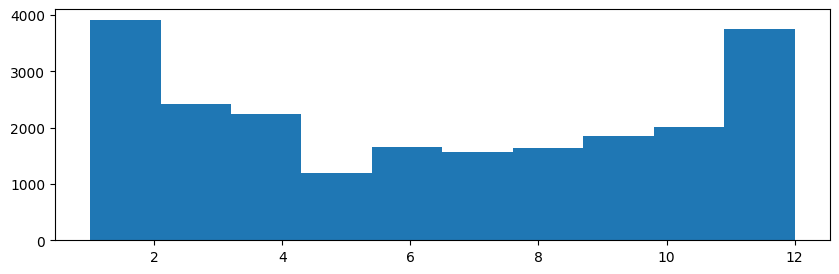

In [73]:
plt.figure(figsize=[10,3])
plt.hist(data_new['month_expo_number'])
plt.show()

In [74]:
data_new['month_expo_number'].value_counts()
#месяцы выражены в числовом формате

2     2494
3     2422
4     2236
11    2232
10    2003
9     1851
6     1651
8     1641
7     1564
12    1522
1     1412
5     1203
Name: month_expo_number, dtype: int64

Самый популярный месяц для выставления объекта на продажу - Февраль. Меньше всего объектов на продажу выставляют в мае.

Изучим дни размещения объявления.

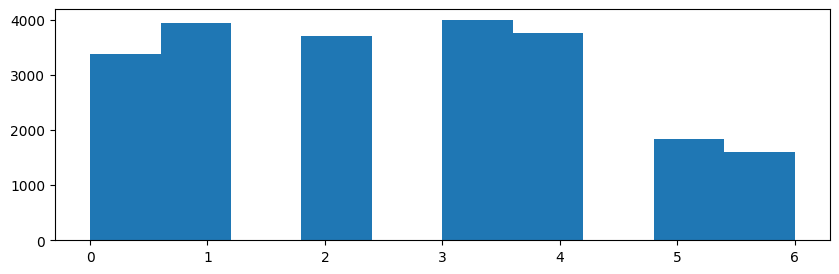

In [75]:
plt.figure(figsize=[10,3])
plt.hist(data_new['day_expo_number'])
plt.show()

In [76]:
data_new['day_expo_number'].value_counts()
#дни недели выражены в числовом формате

3    3996
1    3954
4    3757
2    3702
0    3390
5    1834
6    1598
Name: day_expo_number, dtype: int64

Чаще всего объявления подавались в четверг, затем в вторник. Реже всего объявления подавали в воскресение.

<a id="speed"></a> 
## Как быстро продавались квартиры

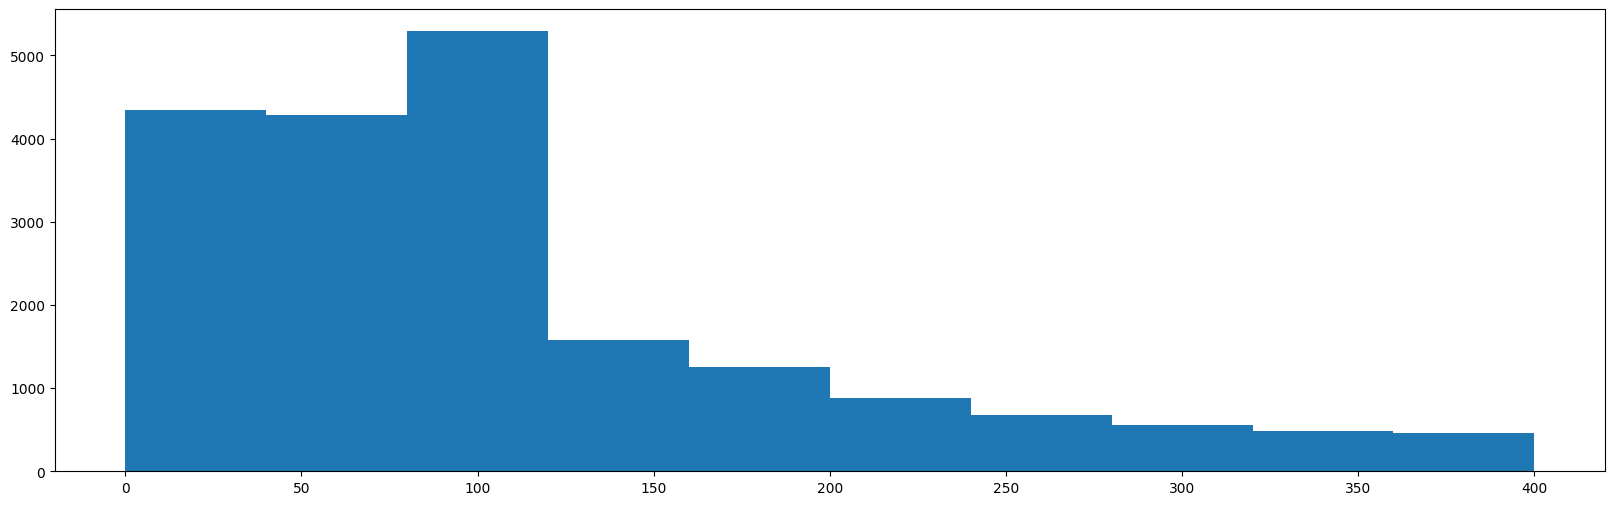

In [77]:
plt.figure(figsize=[20,6])
plt.hist(data_new['days_exposition'], range=(0,400))
plt.show()

In [78]:
data_new['days_exposition'].describe()

count    22231.000000
mean       167.699114
std        204.086114
min          1.000000
25%         45.000000
50%         95.000000
75%        197.000000
max       1580.000000
Name: days_exposition, dtype: float64

Медиана по длительности продажи объектов приходится на 95 дней. Самый долгий объект "висел" 1580 дней. Самая быстрая продажа - 1 день. Квартира - предмет, который, в зависимости от пожеланий владельца, может продаваться достаточно долго. Поэтому срок 1580 дней (более 4 лет)-вполне вероятен. В среднем, квартиры продаются за 200 дней.

Уменьшим диапозон, возможно, обнаружим аномалии:

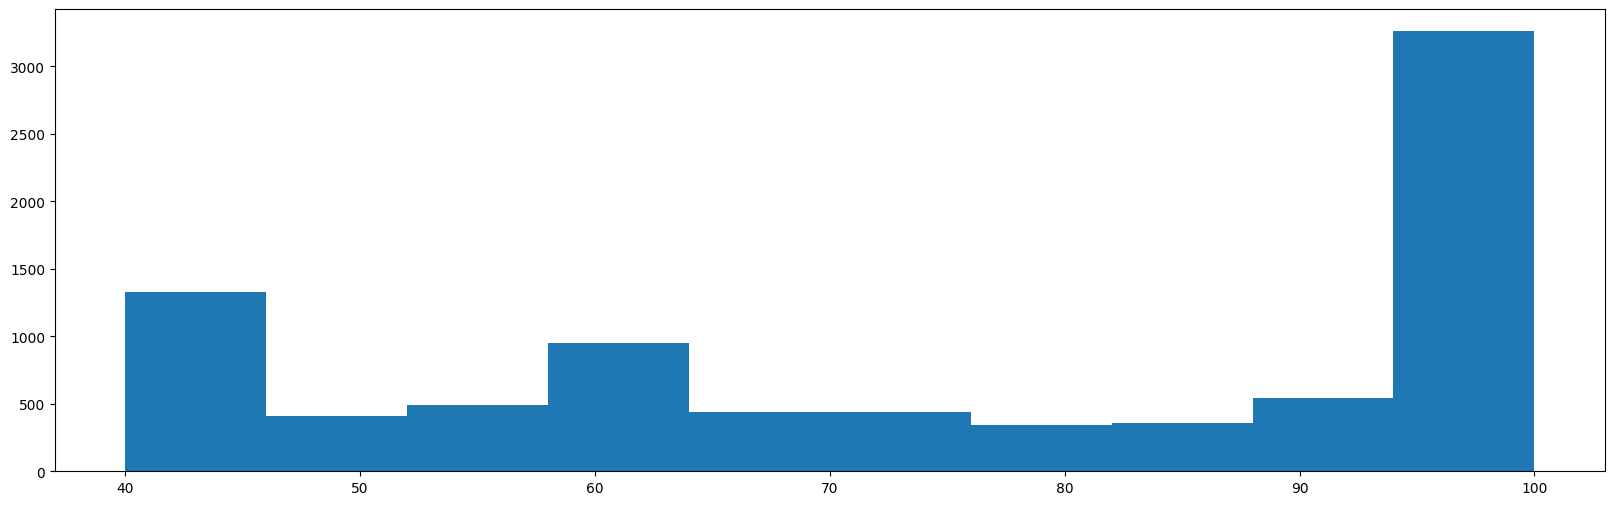

In [79]:
plt.figure(figsize=[20,6])
plt.hist(data_new['days_exposition'], range=(40,100))
plt.show()

Наблюдаем аномалии на 45 и 60 днях с момента выставления объявления. Думаю, это связано со следующими причинами:
- 45 дней для покупки квартиры это оптимальный срок для покупки жилья для тех людей, которые реально ищут жилье для переезда, а не для вложения, или последующей перепродажи: найти, посмотреть, подумать, посмотреть еще раз, проверка квартиры, банковские процедуры. Когда есть цель - найти "свою" квартиру - 45 дней адекватный срок.
- 60 дней - данный пик можно объяснить тем фактом, что некоторым людям требуется больше времени для принятия решения, дополнительные просмотры других объектов, занятость. А продавцы, возможно, идут на скидку для ускорения продажи.

Аномалии на 45 и 60 дней (числа слишком красивые) - похожи на техническую особенность самой платформы. Вероятнее всего, в эти дни платформа удаляет объявления, если пользователь его не продлил

<a id="factors"></a> 
##  Факторы, влияющие на общую (полную) стоимость объекта

1. Определим зависимость цены от общей площади объекта

<AxesSubplot:title={'center':'Зависимость цены от площади объекта'}, xlabel='total_area', ylabel='last_price'>

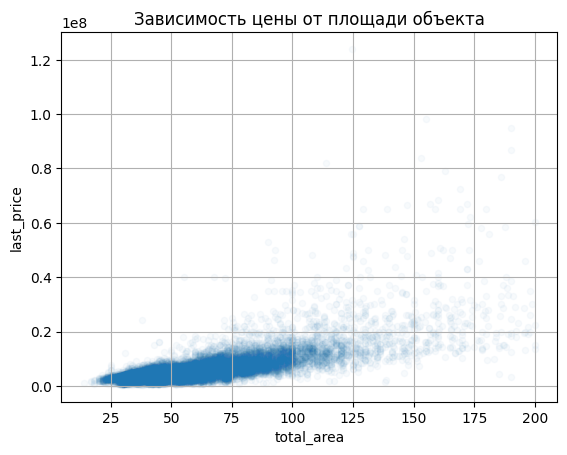

In [80]:
data_new.plot(
    y='last_price',
    x='total_area',
    kind='scatter', alpha=0.03,
    grid=True,
    title='Зависимость цены от площади объекта',
    legend=True)

Расчитаем корреляцию цены и общей площади объектов:

In [81]:
data_new['last_price'].corr(data_new['total_area'])

0.72066859506414

Таким образом, между ценой объекта и его общей площадью однозначно положительная корреляция.

2. Определим зависимость цены от жилой площади объекта

In [82]:
data_new['last_price'].corr(data_new['living_area'])

0.6189478299080554

Также наблюдаем положительную корреляцию.

3. Определим зависимость цены от площади кухни объекта

In [83]:
data_new['last_price'].corr(data_new['kitchen_area'])

0.5335070634667067

Снова наблюдаем положительную корреляцию, хотя и несколько сниженную по сравнению с предыдущими параметрами.

4. Определим зависимость цены от количества комнат объекта

In [84]:
data_new['last_price'].corr(data_new['rooms'])

0.42304390336546177

Есть небольшая положительная корреляция.

5. Определим зависимость цены от типа этажа объекта

In [85]:
floor_pivot = data_new.pivot_table(index='floor_type', values='last_price', aggfunc='median')
floor_pivot


,last_price
floor_type,
другой,4550000.0
первый,4550000.0
последний,4600000.0


Из таблицы можно заметить, что с ростом этажа цена уменьшается, корреляция отрицательная. Построим график для нагрядности.

<AxesSubplot:title={'center':'Зависимость цены от этажа'}, xlabel='floor'>

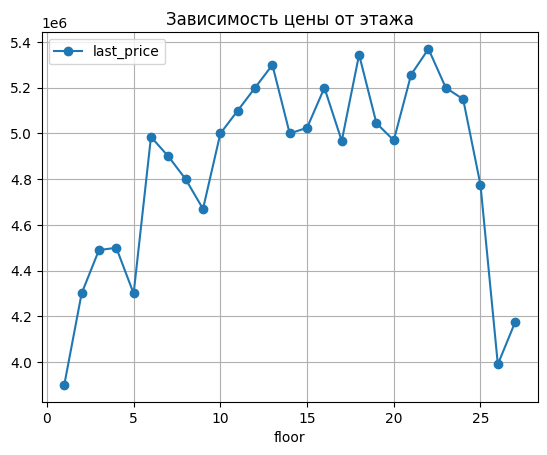

In [86]:
data_new.pivot_table(index='floor', values='last_price', aggfunc='median').plot(style='o-', title='Зависимость цены от этажа',grid=True)

По графику наблюдаем следующее - есть нелинейная положительная корреляция до 22 этажа. Далее корреляция отрицательная с небольшим переходом в положительную корреляцию после 26 этажа(возможно - выброс).

6. Определим зависимость цены от даты размещения объекта

6.1. Сперва оценим зависимость от года размещения объявления

<AxesSubplot:title={'center':'Зависимость цены от года размещения объекта'}, xlabel='year_expo'>

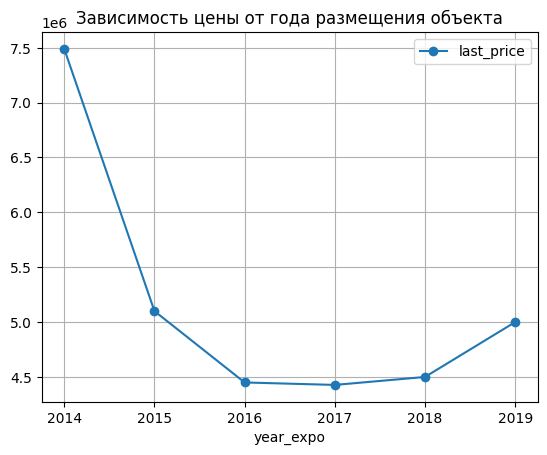

In [87]:
data_new.pivot_table(index='year_expo', values='last_price', aggfunc='median').plot(style='o-', title='Зависимость цены от года размещения объекта',grid=True)

До 2017 года наблюдаем отрицательную корреляцию цены и года размещения. После 2017 корреляция положительная. Причины - макроэкономические.

Построим сводную таблицу с ценой 1м2 и площадью объектов: 

<AxesSubplot:title={'center':'Зависимость цены 1м2 от года размещения объекта'}, xlabel='year_expo'>

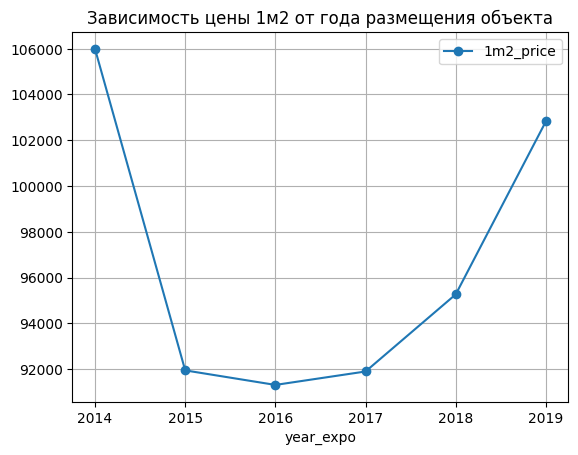

In [88]:
data_new.pivot_table(index='year_expo', values='1m2_price', aggfunc='median').plot(style='o-', title='Зависимость цены 1м2 от года размещения объекта',grid=True)

Также построим сводную таблицу с годом продажи и площадью объектов: 

<AxesSubplot:title={'center':'Зависимость общей площади от года размещения объекта'}, xlabel='year_expo'>

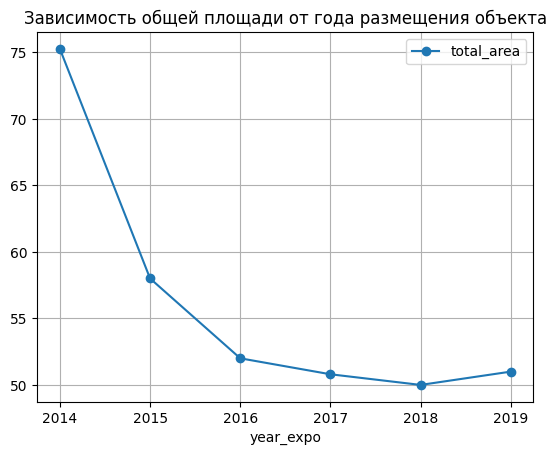

In [89]:
data_new.pivot_table(index='year_expo', values='total_area', aggfunc='median').plot(style='o-', title='Зависимость общей площади от года размещения объекта',grid=True)

Таким образом: совершенно очевидно, что снизилась общая площадь продаваемых квартир и стоимость 1м2 площади. 

6.2. Оценим зависимость от месяца размещения объявления

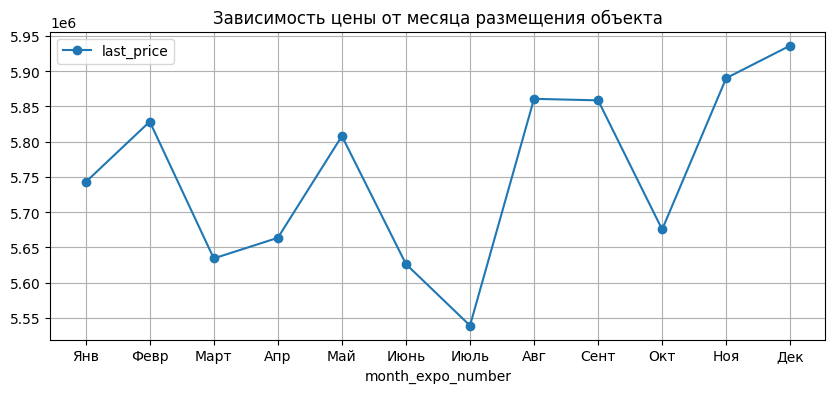

In [90]:
labels = ['Янв', 'Февр', 'Март', 'Апр', 'Май', 'Июнь', 'Июль','Авг', 'Сент', 'Окт', 'Ноя','Дек']
ax = data_new.pivot_table(index='month_expo_number', values='last_price').sort_index().plot(style='o-', title='Зависимость цены от месяца размещения объекта',figsize=(10,4),grid=True)
ax.set_xticks(sorted(data_new['month_expo_number'].unique().tolist()))
ax.set_xticklabels(labels);

Явно положительная корреляция наблюдается с Января по Февраль,с Июня по сентябрь и с Октрября по Декабрь. В остальные месяцы корреляция отрицательная.  

6.3. Оценим зависимость от дня размещения объявления

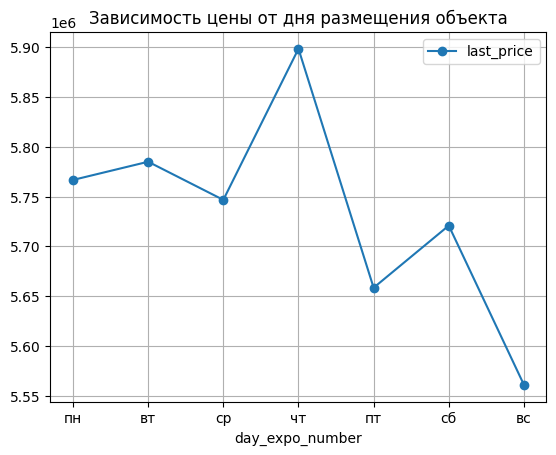

In [91]:
labels = ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']
ax = data_new.pivot_table(index='day_expo_number', values='last_price').sort_index().plot(style='o-', title='Зависимость цены от дня размещения объекта',grid=True)
ax.set_xticks(sorted(data_new['day_expo_number'].unique().tolist()))
ax.set_xticklabels(labels);


Наблюдается корреляция между ценой объекта и днем размещения объявления - с Понедельника по четверг. алее корреляция отрицательная.

6.4. Оценим зависимость от высоты потолков

In [92]:
data_new['last_price'].corr(data_new['ceiling_height'])

0.3830444093096535

Есть незначительная положительная корреляция.

<a id="mean_1scrm_in_10"></a> 
## Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

Выведем 10 населенных пунктов с самым большим количеством объявлений:

In [93]:
top_ten = data_new.pivot_table(index='locality_name',values='1m2_price',aggfunc=['median','count'])
top_ten.columns=['median','count']
top_ten = top_ten.sort_values('count',ascending=False).reset_index().head(10)
top_ten

,locality_name,median,count
0,Санкт-Петербург,103960.400,14613
1,Мурино,85619.700,544
2,поселок Шушары,76876.175,438
3,Всеволожск,65789.470,392
4,Пушкин,99725.495,344
5,Колпино,74722.220,333
6,поселок Парголово,91917.590,325
7,Гатчина,67796.610,305
8,деревня Кудрово,91666.670,286
9,Выборг,58108.110,227


Постороим график Для данных населенных пунктов со средней стоимостю м2:

[Text(0, 0, 'Санкт-Петербург'),
 Text(1, 0, 'Мурино'),
 Text(2, 0, 'поселок Шушары'),
 Text(3, 0, 'Всеволожск'),
 Text(4, 0, 'Пушкин'),
 Text(5, 0, 'Колпино'),
 Text(6, 0, 'поселок Парголово'),
 Text(7, 0, 'Гатчина'),
 Text(8, 0, 'деревня Кудрово'),
 Text(9, 0, 'Выборг')]

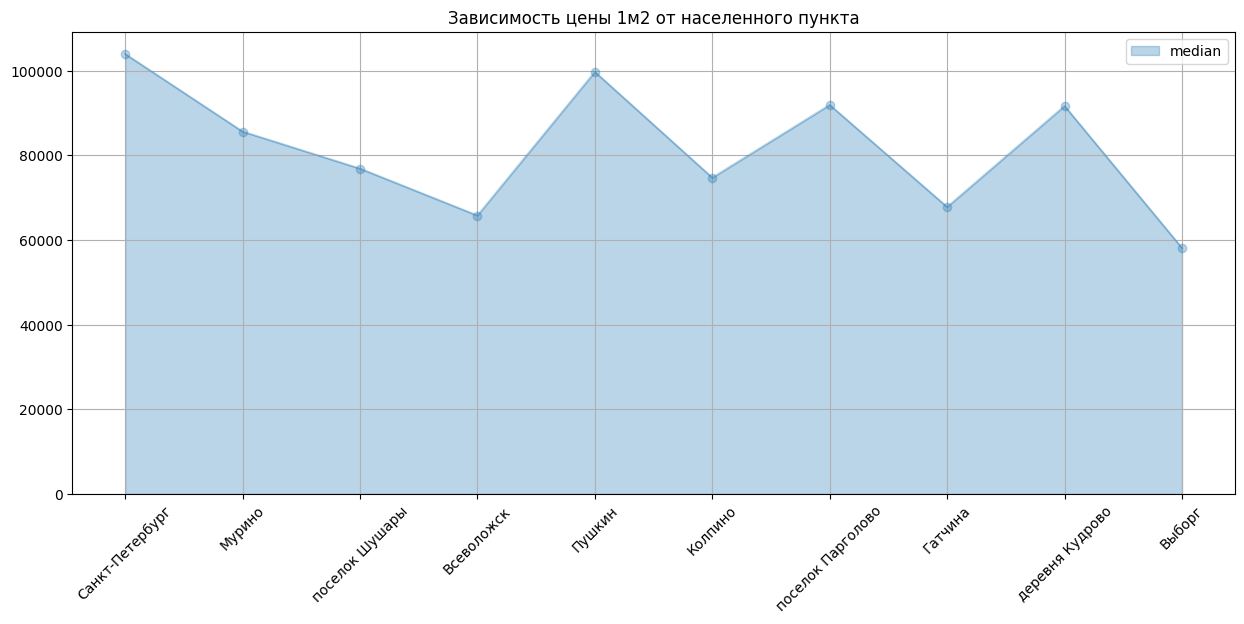

In [94]:
labels = top_ten['locality_name']

ax = top_ten.sort_index().plot(y='median',kind='area', style='o-', alpha=.3, figsize=(15, 6), title='Зависимость цены 1м2 от населенного пункта',grid=True)
ax.set_xticks(list(range(len((top_ten.index.tolist())))))
ax.set_xticklabels(labels,rotation=45)
#Получим график зависимости цены от средней стоимости 1м2 объекта в порядке убывания количества объявлений для каждого НП

Самое высокое значение средней цены одного квадратного метра - в Санкт-Петербурге, далее идет Пушкин и деревня Кудрово. Меньше всего 1м2 площади стоит в Выборге.

<a id="mean_1sqrkm"></a> 
## Вычислим среднюю цену каждого километра до центра города для Санкт-Петербурга.

In [95]:
#cityCenters_nearest_km
data_spb = data_new.query('locality_name=="Санкт-Петербург"')
data_spb.pivot = data_spb.pivot_table(index='cityCenters_nearest_km', values='1m2_price',aggfunc=['median','count'])
data_spb.pivot.columns = ['median','count']
data_spb.pivot

,median,count
cityCenters_nearest_km,,
0.0,144957.980,11
1.0,117366.805,124
2.0,120232.170,199
3.0,108027.780,252
4.0,117235.770,545
5.0,129120.880,727
6.0,131795.450,523
7.0,125000.000,380
8.0,121514.425,546


Постороим график:

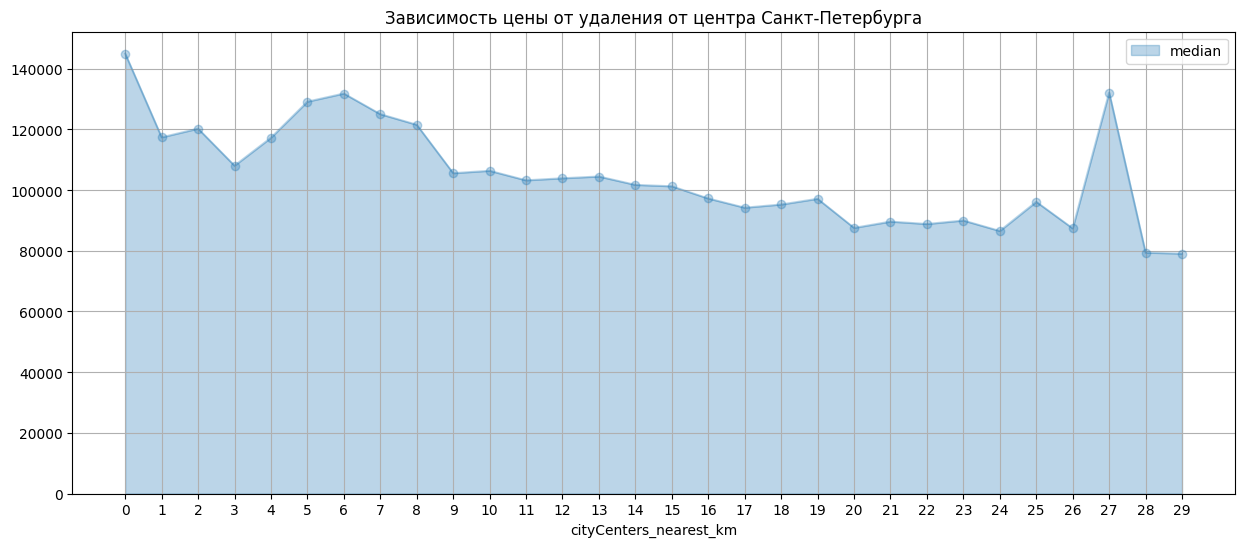

In [96]:
ax = data_spb.pivot.sort_index().plot(y='median',kind='area', style='o-', alpha=.3, figsize=(15, 6), title='Зависимость цены от удаления от центра Санкт-Петербурга',grid=True)
ax.set_xticks(list(range(len((data_spb.pivot.index.tolist())))))


В целом, наблюдаем отрицательную корреляцию стоимости 1м2 площади и расстояния до центра города, что логично. Но на расстоянии 27 км наблюдаем скачок цены.

Примем границу центра города на расстоянии 7-8км. 

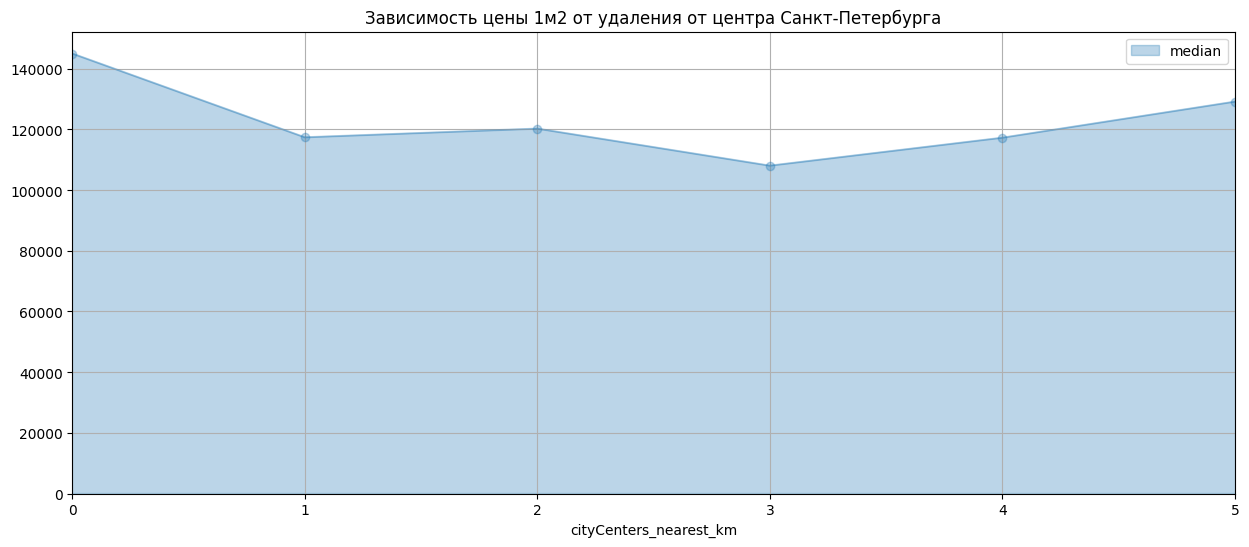

In [97]:
ax = data_spb.pivot.sort_index().plot(y='median',xlim=(0, 5),kind='area', style='o-', alpha=.3, figsize=(15, 6), title='Зависимость цены 1м2 от удаления от центра Санкт-Петербурга',grid=True)

Стоимость жилья падает с удалением от центра до 3км. После 3км наблюдается рост стоимости 1м2.

In [98]:
#Скорее всего на 27км от центра города присутствует выброс, проанализируем данные для этих значений удаления от центра города:
data_spb[data_spb['cityCenters_nearest_km']==27.0]

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,ponds_nearest,days_exposition,1m2_price,day_expo,day_expo_number,month_expo,month_expo_number,year_expo,floor_type,cityCenters_nearest_km
703,748,13,14350000.0,74.0,2017-11-28,2,3.13,5,30.0,3,...,9999,128,193918.92,Tuesday,1,November,11,2017,другой,27.0
5565,5961,6,2250000.0,32.0,2018-02-27,1,2.70,2,16.5,2,...,9999,178,70312.50,Tuesday,1,February,2,2018,другой,27.0


Скорее всего в строке 722 таблицы присутствует ошибка в цене объекта, что и дает скачок на графике. Не будем удалять это значение.

<a id="conclusion"></a> 
# Вывод по исследованию

Итоговый вывод по исследованию:

Перед нами стояла задача найти и проанализировать взаимосвязи между различными параметрами в метрике по продаже объектов недвижимости в Санкт-Петербурге и ближайших к нему населенных пунктов. В ходе решения данной задачи были проведеные следующие действия:

1. исходный файл был подвергнут тщательному анализу на предмет ошибок, пропусков, дубликатов (и здравого смысла): ошибки и дубликаты устранены, пропуски заполнены максимально вероятными значениями.
2. данные очищены от выбросов, вносящих искажения в результаты исследования.
3. сформированы новые столбцы с данными для углубленного и всестороннего анализа взаимосвязей параметров.
4. произведен анализ исходных параметров, влияние на стоимость таких параметров, как общая и жилая площади объектов, площадь кухни, число комнат, тип этажа, расположение объекта. Характеристики объекта в зависимости от даты размещения объекта для продажи.


Как и предполагалось, на стоимость объектов влияет множество факторов:
- Экономическая ситуация и, соответственно, материальные возможности покупателей и соображения продавцов (оценили по зависимости цены от года публикации объявления, а также по зависимости площади объектов от года публикации).
- Расположение объекта - в ходе исследования изучали данные по Санкт-Петербургу и области. Как и следовало ожидать, самые высокие цены на недвижимость в Столице Области.
- Расположение объекта относительно центра города - чем ближе к центру-тем дороже.
- Характеристики самого объектра - общая площадь, жилая площадь, площадь кухни, количество комнат, тип этажа и высота потолков - напрямую влияют на стоимость объекта. Самый главный фактор - общая площадь объекта, здесь самая высокая корреляция с ценой.

Касательно месяца и даты размещения объявления: имеет значение сезонность - летом цены на объекты ниже, осенью начинают значительно расти. Это связано с деятельностью продавцов и покупателей, сезона отпусков и тд.
Касательно дня размещения объявления - с началом недели и до четверга - стоимость обектов растет. После четверга стоимость объектов снижается. 
Касательно длительности размещения объявления о продаже объектов - самая быстрая продажа произошла за 1 день. В среднем квартиры продавались за 95 дней, при этом, наблюдаются аномалии на 45 и 60 днях продажи. Это связано с мотивами покупателей и продавцов. Рекордсмен по длительности - объект, проданный лишь на 5 год.

Задача решена, поставленные цели достигнуты.